In [1]:
import pandas as pd
import numpy as np
import holidays

In [2]:
d_categories = pd.read_csv('./readonly/final_project_data/item_categories.csv')
d_items = pd.read_csv('./readonly/final_project_data/items.csv')
f_train = pd.read_csv('./readonly/final_project_data/sales_train.csv')
d_shops = pd.read_csv('./readonly/final_project_data/shops.csv')
d_test = pd.read_csv('./readonly/final_project_data/test.csv')

In [3]:
print('d_categories:', d_categories.shape, d_categories.columns)
print('d_items:', d_items.shape, d_items.columns)
print('f_train:', f_train.shape, f_train.columns)
print('d_shops:', d_shops.shape, d_shops.columns)
print('d_test:', d_test.shape, d_test.columns)

d_categories: (84, 2) Index(['item_category_name', 'item_category_id'], dtype='object')
d_items: (22170, 3) Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
f_train: (2935849, 6) Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
d_shops: (60, 2) Index(['shop_name', 'shop_id'], dtype='object')
d_test: (214200, 3) Index(['ID', 'shop_id', 'item_id'], dtype='object')


In [4]:
train = pd.merge(f_train, d_items, on = 'item_id').drop(['item_name', 'date_block_num'], axis=1)
train.date = pd.to_datetime(train.date, format='%d.%m.%Y')
train['sales'] = train.item_cnt_day * train.item_price # sales amount of item that day in that shop

In [5]:
november_dates =pd.date_range(start = '2015-11-1',end='2015-11-30', freq='D', name='date').to_series()

In [6]:
test = pd.merge(d_test,november_dates, how = 'cross')
test = pd.merge(test, d_items, on = 'item_id').drop('item_name', axis=1)

In [7]:
traintest = pd.concat([train,test])

In [8]:
traintest.item_price= traintest.groupby(['shop_id','item_id']).ffill().item_price

In [10]:
train.isnull().sum(axis=1).head(15)
train.isnull().sum(axis=0).head(15)

date                0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
sales               0
dtype: int64

No NaNs

In [11]:
train.nunique(dropna=False)

date                 1034
shop_id                60
item_id             21807
item_price          19993
item_cnt_day          198
item_category_id       84
sales               24771
dtype: int64

1034 days, 60 shops, 22k items, 84 item categories

shop_id
54    1.419397e+08
42    1.519170e+08
28    1.597463e+08
25    2.164806e+08
31    2.352170e+08
Name: sales, dtype: float64

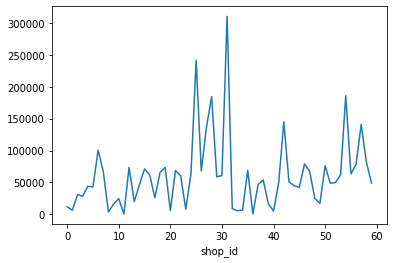

In [13]:
train.groupby('shop_id').item_cnt_day.sum().plot()
train.groupby('shop_id').item_cnt_day.sum().sort_values().tail()

#train.groupby('shop_id').sales.sum().plot()
train.groupby('shop_id').sales.sum().sort_values().tail()

shop_id 31,25 have the most net transactions, and also the highest sales and revenue

shop_id
42    1.326591
55    1.823118
12    2.117888
20    3.276786
9     4.229805
Name: item_cnt_day, dtype: float64

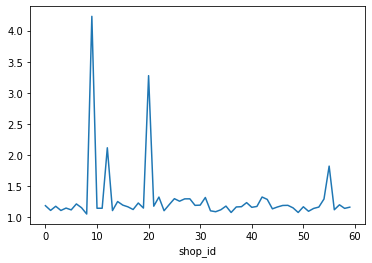

In [14]:
train.groupby('shop_id').item_cnt_day.mean().plot()
train.groupby('shop_id').item_cnt_day.mean().sort_values().tail()

shop_id 9,20,12,55 have the most items sold per day

In [15]:
train.item_price.value_counts()

299.00     291352
399.00     242603
149.00     218432
199.00     184044
349.00     101461
            ...  
345.57          1
318.71          1
318.09          1
340.49          1
4040.00         1
Name: item_price, Length: 19993, dtype: int64

A lot of item prices end with 9. Use this fact as a feature.

In [16]:
def ends_with_9(x):
    if str(x)[-3] == '9':
        return True
    else:
        return False

def ends_with_49(x):
    if str(x)[-4:][0:2] == '49':
        return True
    else:
        return False

def ends_with_99(x):
    if str(x)[-4:][0:2] == '09':
        return True
    else:
        return False

traintest['ends_with_9'] = traintest.item_price.apply(ends_with_9)
traintest['ends_with_49'] = traintest.item_price.apply(ends_with_49)
traintest['ends_with_99'] = traintest.item_price.apply(ends_with_99)

In [17]:
traintest.ends_with_9.value_counts()
#traintest.ends_with_49.value_counts()
#traintest.ends_with_99.value_counts()

True     5316478
False    4045371
Name: ends_with_9, dtype: int64

3196.0

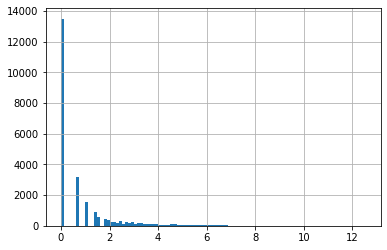

In [19]:
train.sales.value_counts().apply(np.log).hist(bins=100)
train.sales.quantile(q=0.95)

Sales are extremely unevenly distributed, with 50% of sales occurring below 449. Separate items into quantiles.

In [20]:
q_99 = train.item_price.quantile(q=0.99)
q_95 = train.item_price.quantile(q=0.95)
q_50 = train.item_price.quantile(q=0.5)

traintest['item_price_below_q99'] = traintest.item_price.apply(lambda x: x <= q_99)
traintest['item_price_below_q95'] = traintest.item_price.apply(lambda x: x <= q_95)
traintest['item_price_below_q50'] = traintest.item_price.apply(lambda x: x <= q_50)

<AxesSubplot:>

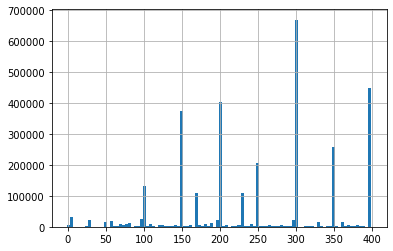

In [21]:
traintest.item_price[traintest.item_price_below_q50].hist(bins=100)

Here we also see the behaviour we captured above: almost all item prices end with 49 or 99.

Relationship between item prices and item categories

array([[<AxesSubplot:title={'center':'item_price'}>]], dtype=object)

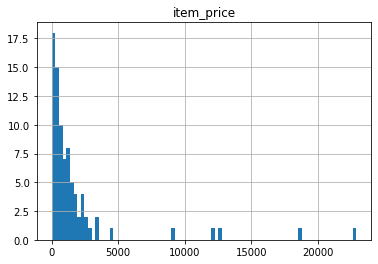

In [22]:
train.groupby('item_category_id').mean().sort_values('item_price')[['item_price']].hist(bins=84)

<AxesSubplot:>

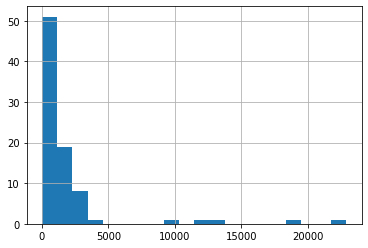

In [23]:
mean_category_price = train.groupby('item_category_id').mean().item_price
mean_category_price.hist(bins=20)

In [25]:
# Top 5 categories by item price
category_top5_price = train.groupby('item_category_id').mean().sort_values('item_price', ascending=False).head(5).index.values
# Top 10 categories by item price
category_top10_price = train.groupby('item_category_id').mean().sort_values('item_price', ascending=False).head(10).index.values
# Top 20 categories by item price
category_top20_price = train.groupby('item_category_id').mean().sort_values('item_price', ascending=False).head(20).index.values

# Top 5 categories by item count
category_top5_cnt = train.groupby('item_category_id').mean().sort_values('item_cnt_day', ascending=False).head(5).index.values
# Top 10 categories by item count
category_top10_cnt = train.groupby('item_category_id').mean().sort_values('item_cnt_day', ascending=False).head(10).index.values
# Top 20 categories by item count
category_top20_cnt = train.groupby('item_category_id').mean().sort_values('item_cnt_day', ascending=False).head(20).index.values




In [26]:
traintest['category_top5_price'] = traintest.item_category_id.isin(category_top5_price)
traintest['category_top10_price'] = traintest.item_category_id.isin(category_top10_price)
traintest['category_top20_price'] = traintest.item_category_id.isin(category_top20_price)

traintest['category_top5_cnt'] = traintest.item_category_id.isin(category_top5_cnt)
traintest['category_top10_cnt'] = traintest.item_category_id.isin(category_top10_cnt)
traintest['category_top20_cnt'] = traintest.item_category_id.isin(category_top20_cnt)

In [27]:
traintest['weekday'] = traintest.date.apply(lambda x: x.weekday())
russian_holidays = holidays.RU()
traintest['holiday'] = traintest.date.isin(russian_holidays)

In [29]:
traintest.to_pickle('./traintest.p')

In [32]:
traintest.to_csv('test.csv')

KeyboardInterrupt: 